In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
print("Loading the dataset...")
dataset_name = "oxford_flowers102"
dataset, dataset_info = tfds.load(dataset_name, as_supervised=True, with_info=True)


Loading the dataset...


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.YJO96X_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...:   0%|          | 0/6149 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.YJO96X_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.YJO96X_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


In [ ]:
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [ ]:
num_classes = dataset_info.features['label'].num_classes
num_train = dataset_info.splits['train'].num_examples
num_val = dataset_info.splits['validation'].num_examples
num_test = dataset_info.splits['test'].num_examples
print(f"Training samples: {num_train}, Validation samples: {num_val}, Test samples: {num_test}")
print(f"Number of classes: {num_classes}")


Training samples: 1020, Validation samples: 1020, Test samples: 6149
Number of classes: 102


In [ ]:
# Print the shape and corresponding label of 3 images in the training set
for image, label in train_data.take(3):
    print(f"Image shape: {image.shape}, Label: {label.numpy()}")

Image shape: (500, 667, 3), Label: 72
Image shape: (500, 666, 3), Label: 84
Image shape: (670, 500, 3), Label: 70


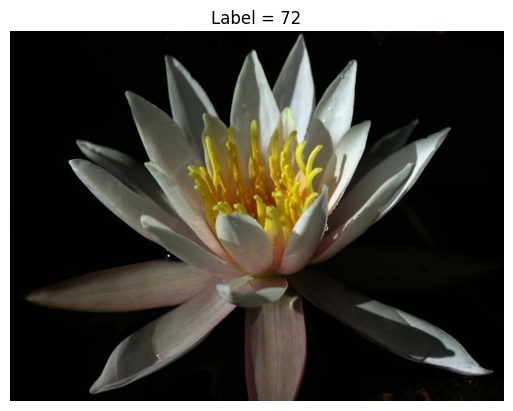

In [ ]:
# Plot 1 image from the training set. Set the title
# of the plot to the corresponding image label.
for image, label in train_data.take(1):
    plt.imshow(image)
    plt.title(f"Label = {label.numpy()}")
    plt.axis('off')
    plt.show()

In [ ]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

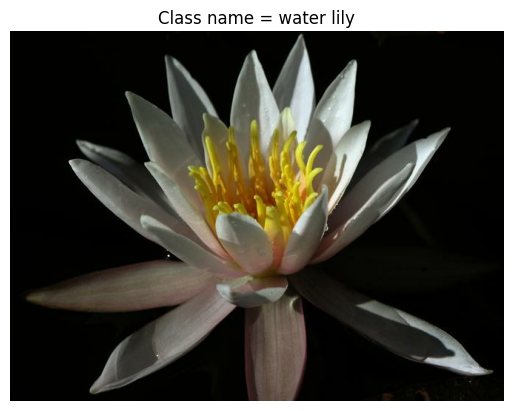

In [ ]:
# Plot 1 image from the training set. Set the title
# of the plot to the corresponding class name.
for image, label in train_data.take(1):
    plt.imshow(image)
    class_idx = label.numpy()
    label_str = class_names.get(str(class_idx), f"Class_{class_idx}")
    plt.title(f"Class name = {label_str}")
    plt.axis('off')
    plt.show()

In [ ]:
#create pipeline
batch_size = 32
image_size = 224

num_training_examples = dataset_info.splits['train'].num_examples
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    return image, label


training_batches = train_data.shuffle(num_training_examples // 4) \
                           .map(normalize) \
                           .batch(batch_size) \
                           .prefetch(1)

validation_batches = val_data.map(normalize) \
                           .batch(batch_size) \
                           .prefetch(1)

testing_batches = test_data.map(normalize) \
                         .batch(batch_size) \
                         .prefetch(1)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models

num_classes = 102

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

history = model.fit(
    training_batches,
    validation_data=validation_batches,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 151s 5s/step - accuracy: 0.0320 - loss: 4.9694 - val_accuracy: 0.1667 - val_loss: 3.9875 - learning_rate: 0.0010
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 195s 4s/step - accuracy: 0.2667 - loss: 3.2033 - val_accuracy: 0.3686 - val_loss: 3.3743 - learning_rate: 0.0010
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.4602 - loss: 2.5037 - val_accuracy: 0.5049 - val_loss: 2.8885 - learning_rate: 0.0010
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.5794 - loss: 2.0081 - val_accuracy: 0.5853 - val_loss: 2.4698 - learning_rate: 0.0010
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 179s 4s/step - accuracy: 0.6902 - loss: 1.6506 - val_accuracy: 0.6480 - val_loss: 2.1264 - learning_rate: 0.0010
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step - accuracy: 0.7190 - loss: 1.3938 - val_accuracy: 0.6863 - val_loss: 1.8576 - learning_rate: 0.0010
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 

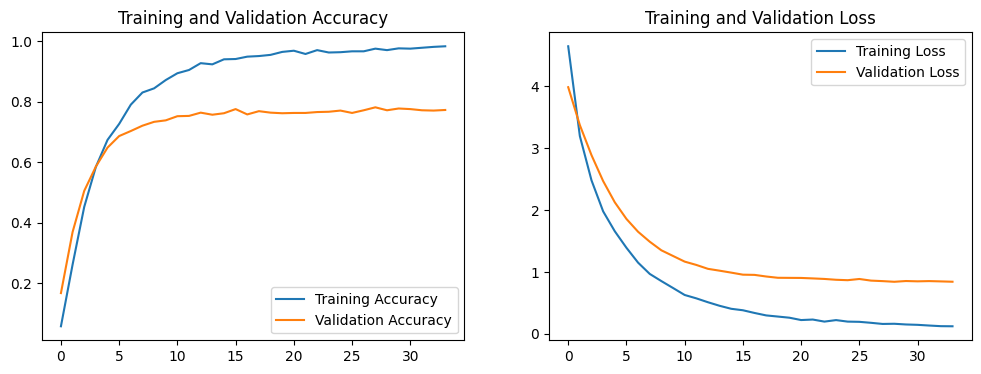

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
#Print the loss and accuracy values achieved on the entire test set.
test_loss, test_acc = model.evaluate(testing_batches)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.7414 - loss: 1.0086
Test Loss: 1.0205013751983643
Test Accuracy: 0.7399576902389526


In [ ]:
# Save your trained model as a Keras model.
model.save('flower_classifier.h5')
print("The Model has beem saved as flower_classifier.h5")

The Model has beem saved as flower_classifier.h5


In [ ]:
#Load the Keras model

loaded_model = tf.keras.models.load_model('flower_classifier.h5')
print("The Model has been reloaded successfully.")

The Model has been reloaded successfully.


In [ ]:
#Create the process_image function
def process_image(np_image):

    img_tensor = tf.convert_to_tensor(np_image, dtype=tf.float32)
    img_tensor = tf.image.resize(img_tensor, (image_size, image_size))
    img_tensor /= 255

    return img_tensor.numpy()


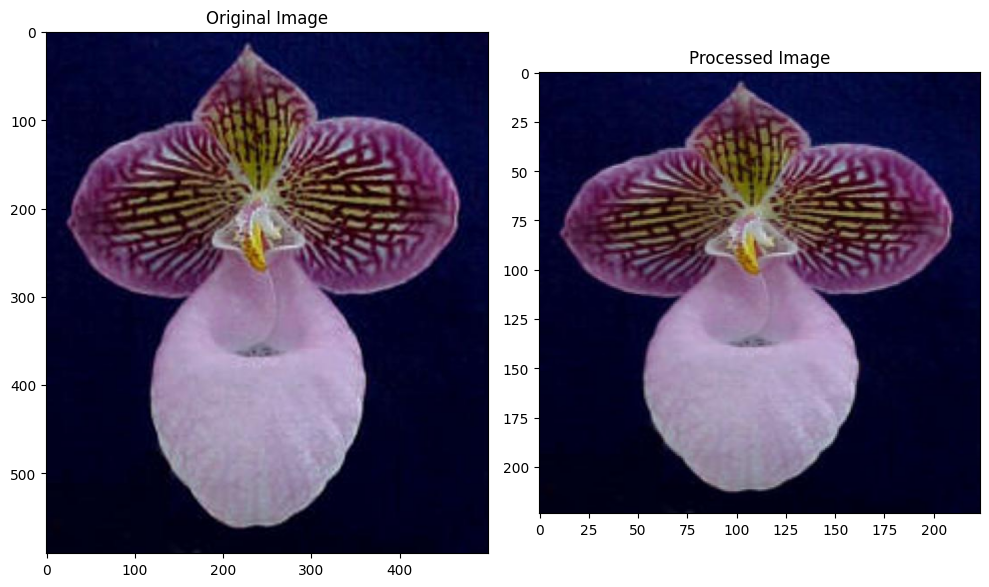

In [ ]:
from PIL import Image

image_path = '/content/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [ ]:
#  Create the predict function

def predict(image_path, model, top_k=5):

    im = Image.open(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis=0)

    probs = model.predict(processed_test_image)[0]

    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]

    return top_probs, top_indices



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


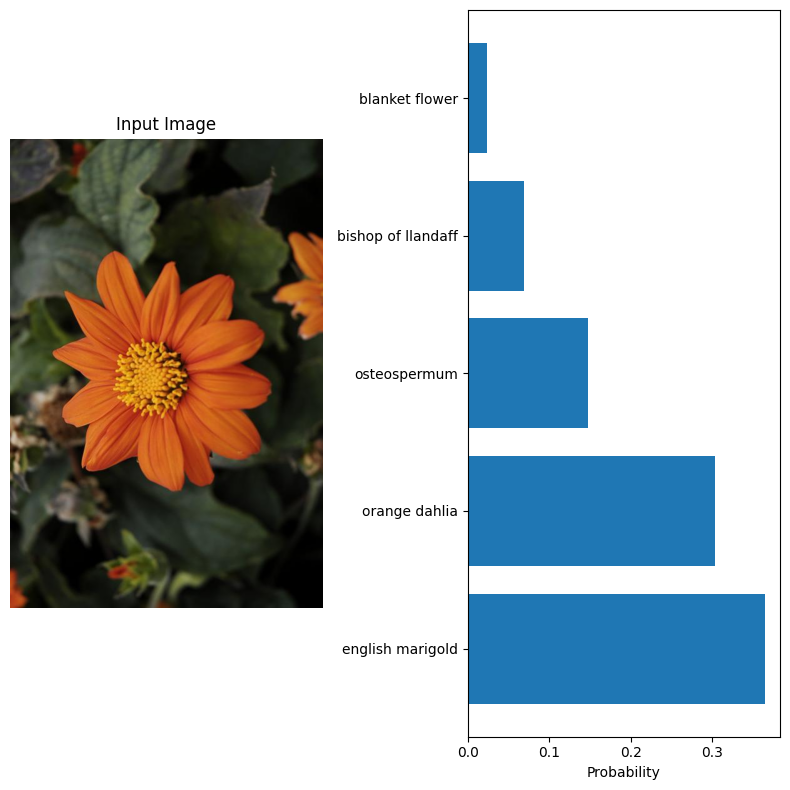

In [ ]:
 #Plot the input image along with the top 5 classes

def plot_predictions(image_path, model, top_k=5, class_names=None):
    probs, indices = predict(image_path, model, top_k=top_k)

    im = Image.open(image_path)

    if class_names:
        label_strings = [class_names.get(str(i), f"Class_{i}") for i in indices]
    else:
        label_strings = [f"Class_{i}" for i in indices]

    fig, (ax1, ax2) = plt.subplots(figsize=(8,8), ncols=2)
    ax1.imshow(im)
    ax1.axis('off')

    y_pos = np.arange(len(label_strings))
    ax2.barh(y_pos, probs[::-1])
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(label_strings[::-1])
    ax2.invert_yaxis()
    ax2.set_xlabel('Probability')
    ax1.set_title("Input Image")

    plt.tight_layout()
    plt.show()

plot_predictions('/content/orange_dahlia.jpg',
                 loaded_model,
                 top_k=5,
                 class_names=class_names)


In [ ]:
#@title Todo predict.py
training_py_file = r"""
import argparse
import numpy as np
import json
from PIL import Image
import tensorflow as tf

def process_image(np_image):
    np_image = tf.convert_to_tensor(np_image, dtype=tf.float32)
    np_image = tf.image.resize(np_image, (224, 224))
    np_image /= 255.0
    return np_image.numpy()

def predict(image_path, model, top_k=5):
    im = Image.open(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    processed_test_image = np.expand_dims(processed_test_image, axis=0)
    probs = model.predict(processed_test_image)[0]
    top_indices = np.argsort(probs)[-top_k:][::-1]
    top_probs = probs[top_indices]
    return top_probs, top_indices

def main():
    parser = argparse.ArgumentParser(description='Predict flower name from an image.')
    parser.add_argument('image_path', type=str, help='Path to image')
    parser.add_argument('model_path', type=str, help='Path to Keras model (h5 file)')
    parser.add_argument('--top_k', type=int, default=5, help='Number of top predictions to return')
    parser.add_argument('--category_names', type=str, default='label_map.json', help='Path to label map JSON')
    args = parser.parse_args()

    # Load model
    model = tf.keras.models.load_model(args.model_path)

    # Load label map if available
    with open(args.category_names, 'r') as f:
        class_names = json.load(f)

    top_probs, top_indices = predict(args.image_path, model, top_k=args.top_k)

    # Print results
    print("Top K Classes & Probabilities:")
    for i, idx in enumerate(top_indices):
        label_str = class_names.get(str(idx), f"Class_{idx}")
        print(f"{i+1}. {label_str} - Probability: {top_probs[i]:.4f}")

if __name__ == '__main__':
    main()
"""

In [ ]:
# prompt: create the predict.py from the str training_py_file

with open('predict.py', 'w') as f:
  f.write(training_py_file)